# Ay119: Deep learning

This assignment builds a deep learning classifier. 

In [ ]:
!git clone https://github.com/dmitryduev/ay119.git

fatal: destination path 'ay119' already exists and is not an empty directory.


In [ ]:
path_base = '/content/'
path_data = '/content/ay119/deep_learning/data'

# path_base = './'
# path_data = './data'

## The problem: the `rbp` classifier for the `GTF`

 You are running a state-of-the-art *robotic* sky survey called the Geeky Transient Facility,
 or GTF, perhaps somewhere in the Southern Hemisphere.
 You have a fancy image-differencing pipeline that allows you to find interesting objects in the
 dynamic sky every night, such as supernovae, variable stars, and asteroids, and send them
 out to the world as alerts.

 However you notice two things:

 1. Your fancy image-differencing pipeline produces a lot of bogus detections.
 With the increasing data rates you are worried that one day you will run out of
 graduate students to examine/scan the potentially interesting candidate sources.

 2. Your AGI-based robot-telescope is extraordinarily sophisticated and smart,
 but has one major soft spot: it really likes platypuses. In fact, the robot likes them
 so much (obsessed, really) that whenever a platypus appears in the vicinity, it halts observing
 and instead takes a picture of it and sends it out as an alert.

So you decide to build a `real, bogus, or platypus` (`rbp` for short) classifier for GTF.


## Transfer learning

You are not the first one to encounter a problem like this, so you decide to apply the
[*transfer learning*](https://www.tensorflow.org/tutorials/images/transfer_learning)
technique and use the real-bogus classifier `braai` that is employed
by a similar survey called [ZTF](https://ztf.caltech.edu) running in the Northern Hemisphere.


Import the necessities:

In [ ]:
from astropy.visualization import ZScaleInterval
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


### The model

Download a pre-trained model:

In [ ]:
model_name = 'braai_d6_m9.h5'

if not (pathlib.Path(path_data) / model_name).exists():
    !wget https://github.com/dmitryduev/kowalski/raw/master/kowalski/models/braai_d6_m9.h5

--2020-05-28 00:56:21--  https://github.com/dmitryduev/kowalski/raw/master/kowalski/models/braai_d6_m9.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dmitryduev/kowalski/master/kowalski/models/braai_d6_m9.h5 [following]
--2020-05-28 00:56:22--  https://raw.githubusercontent.com/dmitryduev/kowalski/master/kowalski/models/braai_d6_m9.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3809888 (3.6M) [application/octet-stream]
Saving to: ‘braai_d6_m9.h5.3’

braai_d6_m9.h5.3    100%[===================>]   3.63M  --.-KB/s    in 0.08s   

2020-05-28 00:56:22 (43.1 MB/s) - ‘braai_d6_m9.h5.3’ saved [3809

Load the model and examine its architecture:

In [ ]:
model = tf.keras.models.load_model('braai_d6_m9.h5')


In [ ]:
model.summary()

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0      

We will be using the [functional API of `tf.keras`](https://www.tensorflow.org/guide/keras/functional).

Next, remove the output layer, but leave the feature extraction part of the network in place:

In [ ]:
model.layers[-2]

In [ ]:
model_fe = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model_fe.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 63, 63, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248  

Create a new output layer that will provide the probabilities for our three classes.
Hint: you will need 3 output neurons and the softmax activation function.

In [ ]:
output = tf.keras.layers.Dense(3, activation="softmax")(model_fe.output)

In [ ]:
model_tl = tf.keras.Model(inputs=model_fe.inputs, outputs=output)

In [ ]:
model_tl.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_input (InputLayer)     [(None, 63, 63, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248

The new model architecture is ready! You may optionally "freeze" the weights in the feature-extracting
part of the network and only train the "head" of the network that does the classification -- feel
free to play around with this once you're done with the exercise.

In [ ]:
# mark layers as not trainable
# for layer in model_tl.layers[:-1]:
# 	layer.trainable = False

You can now compile the model and it is ready for training!

Hints:
- The [Adam optizimer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
  with the default settings is usually a good starting point
- You will need the [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss function
- You can try to use the standard [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) to track the performance such as
accuracy, precision, recall, and area under curve, or code your own one!

In [ ]:
model_tl.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### The data

You have collected training examples and now need to make a dataset out of them.

In [ ]:
p = pathlib.Path(path_data)

bogus = np.array([np.load(pp) for pp in (p / 'bogus').glob('*.npy')])
real = np.array([np.load(pp) for pp in (p / 'real').glob('*.npy')])
platypus = np.array([np.load(pp) for pp in (p / 'platypus').glob('*.npy')])

data = np.vstack((bogus, real, platypus))

In [ ]:
bogus.shape, real.shape, platypus.shape

((100, 63, 63, 3), (100, 63, 63, 3), (51, 63, 63, 3))

Make labels:

In [ ]:
indices = [0 for _ in range(bogus.shape[0])] +\
    [1 for _ in range(real.shape[0])] +\
    [2 for _ in range(platypus.shape[0])]
labels = tf.one_hot(indices, depth=3, dtype=tf.int8).numpy()
# labels


Train/validation/test split (we will use an 81\% / 9\% / 10\% data split):

In [ ]:
test_size = 0.1
val_size = 0.1
random_state = 42

train_indexes, test_indexes = train_test_split(range(len(labels)), shuffle=True,
                                               test_size=test_size, random_state=random_state)
train_indexes, val_indexes = train_test_split(train_indexes, shuffle=True,
                                              test_size=val_size, random_state=random_state)

In [ ]:
batch_size = 4
shuffle_buffer_size = 4

epochs = 20

We will feed the model with data stored as `tf.data.Dataset`'s.

Hint: use the `tf.data.Dataset.from_tensor_slices` method.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((data[train_indexes], labels[train_indexes]))
val_dataset = tf.data.Dataset.from_tensor_slices((data[val_indexes], labels[val_indexes]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[test_indexes], labels[test_indexes]))

Now shuffle, batch, and repeat the data. Let's also apply some data augmentation (random horizontal
and vertical flips) to make the classifier more robust:

In [ ]:
# train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
# flipping:
train_dataset = train_dataset.cache().map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).map(
    lambda image, label: (tf.image.random_flip_up_down(image), label)
).shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
val_dataset = val_dataset.batch(batch_size).repeat(epochs)
test_dataset = test_dataset.batch(batch_size)

We now need to compute for how many epochs to train, validate, and test the classifier:

In [ ]:
steps_per_epoch_train = len(train_indexes) // batch_size - 1
steps_per_epoch_val = len(val_indexes) // batch_size - 1
steps_per_epoch_test = len(test_indexes) // batch_size - 1
steps_per_epoch_train, steps_per_epoch_val, steps_per_epoch_test

(49, 4, 5)

We don't want to [overfit](https://en.wikipedia.org/wiki/Overfitting),
so we will halt training if the loss on the validation dataset is not
improving for, say 5 consecutive epochs.

Hint: Look for a suitable callback in `tf.keras.callbacks` and
monitor `val_loss` and restore the best weights

Let's also make progress bars look nicer and use the `TqdmCallback` callback.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tqdm_callback = TqdmCallback(verbose=1)

callbacks = [
    early_stopping_callback,
    tqdm_callback]

We are ready to fit the model!

Hint: you'll need the `fit` method. Set `verbose=0` for `TqdmCallback` to work properly.

In [ ]:
# Doing with only early_stopping_callback
h =model_tl.fit(train_dataset, 
                steps_per_epoch = steps_per_epoch_train,
                validation_data = val_dataset,
                validation_steps = steps_per_epoch_val,
                epochs = epochs,
                callbacks = [early_stopping_callback],
                verbose = 1)
'''
h = model.fit_generator(training_generator,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=validation_generator,
                        validation_steps=(len(x_train)*validation_split) // batch_size,
                        class_weight=class_weight,
                        epochs=epochs,
                        verbose=1, callbacks=[early_stopping])
'''

Epoch 1/20
49/49 [==============================] - 2s 47ms/step - loss: 0.2398 - accuracy: 0.9031 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/20
49/49 [==============================] - 2s 38ms/step - loss: 0.0865 - accuracy: 0.9691 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 3/20
49/49 [==============================] - 2s 38ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.9515e-04 - val_accuracy: 1.0000
Epoch 4/20
49/49 [==============================] - 2s 38ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.3112e-04 - val_accuracy: 1.0000
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.4766e-05 - val_accuracy: 1.0000
Epoch 6/20
49/49 [==============================] - 2s 37ms/step - loss: 0.0045 - accuracy: 0.9948 - val_loss: 2.1240e-05 - val_accuracy: 1.0000
Epoch 7/20
49/49 [==============================] - 2s 37ms/step - loss: 0.0962 - accuracy: 0.9794 - val_loss: 0.0017 - val_accuracy: 1.00

'\nh = model.fit_generator(training_generator,\n                        steps_per_epoch=len(x_train) // batch_size,\n                        validation_data=validation_generator,\n                        validation_steps=(len(x_train)*validation_split) // batch_size,\n                        class_weight=class_weight,\n                        epochs=epochs,\n                        verbose=1, callbacks=[early_stopping])\n'

Great! The model is trained and we can now evaluate it on the test set:

In [ ]:
model_tl.evaluate(test_dataset)

7/7 [==============================] - 0s 10ms/step - loss: 1.4409e-04 - accuracy: 1.0000


[0.00014409478171728551, 1.0]

Let's visualize our model's predictions:

'real:'

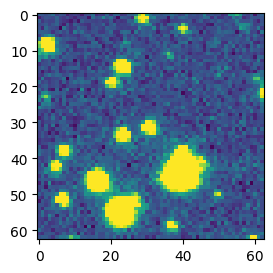

'bogus:'

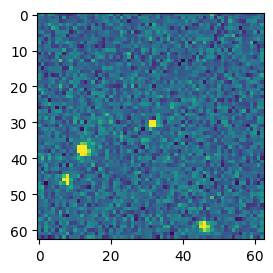

'real:'

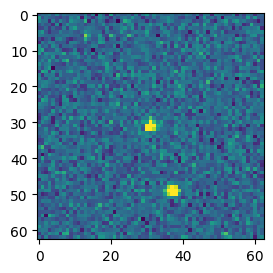

'bogus:'

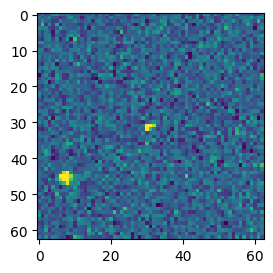

'real:'

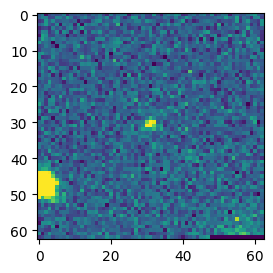

'real:'

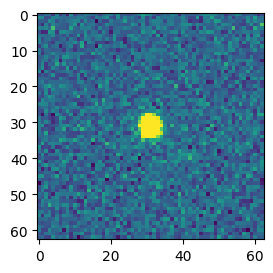

'real:'

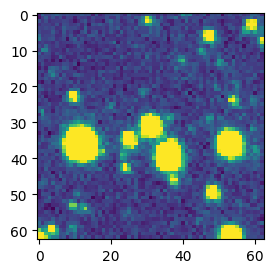

'platypus:'

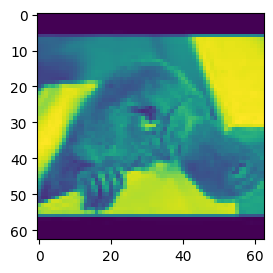

'bogus:'

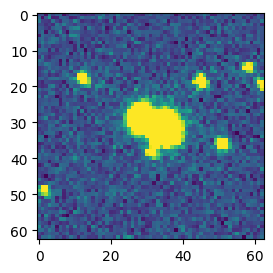

'real:'

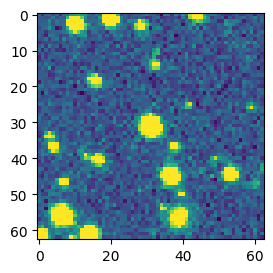

'real:'

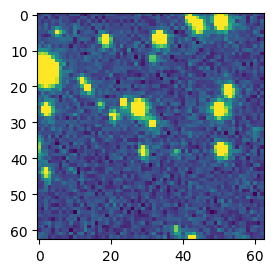

'platypus:'

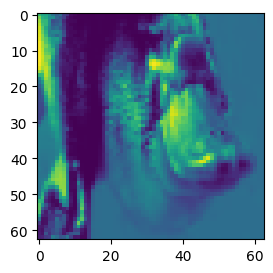

'platypus:'

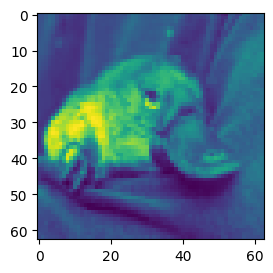

'real:'

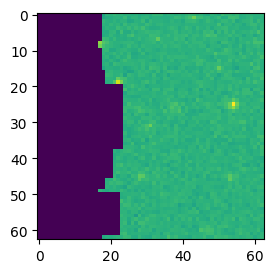

'bogus:'

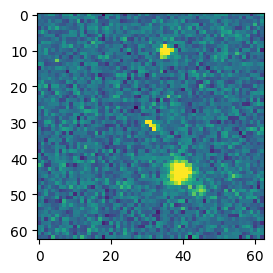

'platypus:'

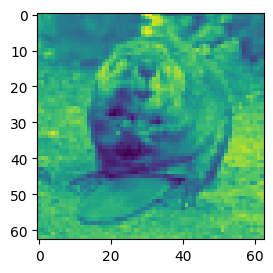

'real:'

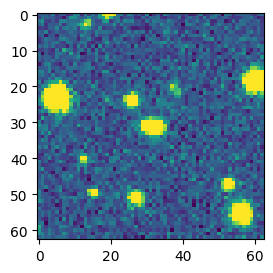

'bogus:'

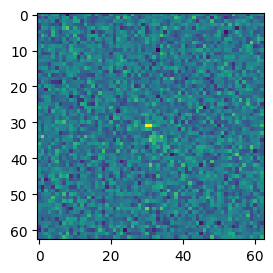

'real:'

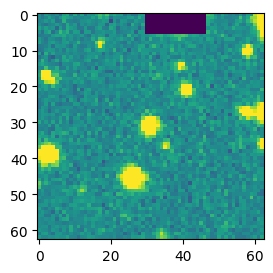

'bogus:'

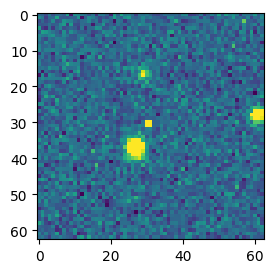

'platypus:'

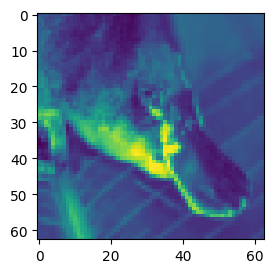

'bogus:'

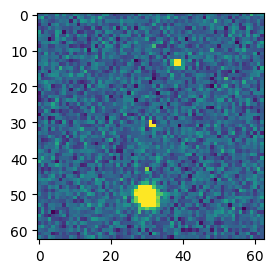

'real:'

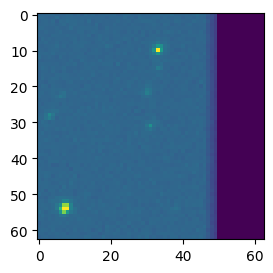

'bogus:'

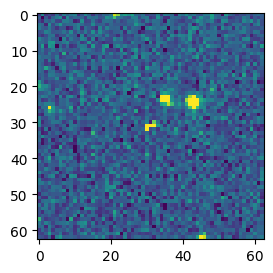

'real:'

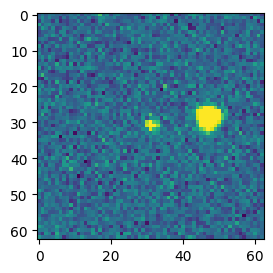

'bogus:'

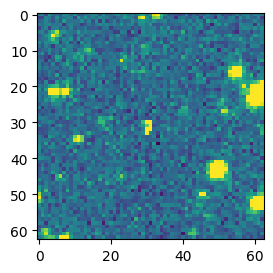

In [ ]:
ll = {0: 'bogus', 1: 'real', 2: 'platypus'}

for ii in test_indexes:
    interval = ZScaleInterval()
    limits = interval.get_limits(data[ii, ..., 0])

    fig = plt.figure(figsize=(3, 3), dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(data[ii, ..., 0], vmin=limits[0], vmax=limits[1])

    p = np.argmax(model_tl.predict(np.expand_dims(data[ii], axis=0))[0])
    display(f"{ll[p]}:")

    plt.show()
    # break